# Package Installation

In [1]:
options(repr.plot.width=20, repr.plot.height=10, warn=1)
install.packages('pacman')

Installing package into 'C:/Users/kenri/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\kenri\AppData\Local\Temp\RtmpSUmdXD\downloaded_packages


In [2]:
pacman::p_load(readxl, zoo, dlm, stats4, sde, statmod, fastGHQuad)

In [3]:
library(readxl)
library(zoo)
library(dlm)
library(stats4)
library(sde)
library(tseries)
library(statmod)
library(splines)
library(fastGHQuad)

Warning message:
"package 'tseries' was built under R version 4.1.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# Cointegrated Pair

In [4]:
df = read_excel("cointegratedSpread1min.xlsx")
spread = df[, 2][[1]]

# Generate a random normal process
# rnorm2 <- function(n,mean,sd) { mean+sd*scale(rnorm(n)) }
# spread = rnorm2(780,mean=0,sd=1)
# mean(spread)

New names:
* `` -> ...3
* `` -> ...4
* `` -> ...5



We homogenize the boundary conditions by applying the linear transformation $v(x) = u(x) - x$, where $u(x)$ denotes the spread and $u_0 = x$ 

In [5]:
initialValue = spread[1]
spread = spread - initialValue

We model the spread of two cointegrated assets as 

$ dU_t = -\mu  U_tdt + \sigma dW_t + dN_t $

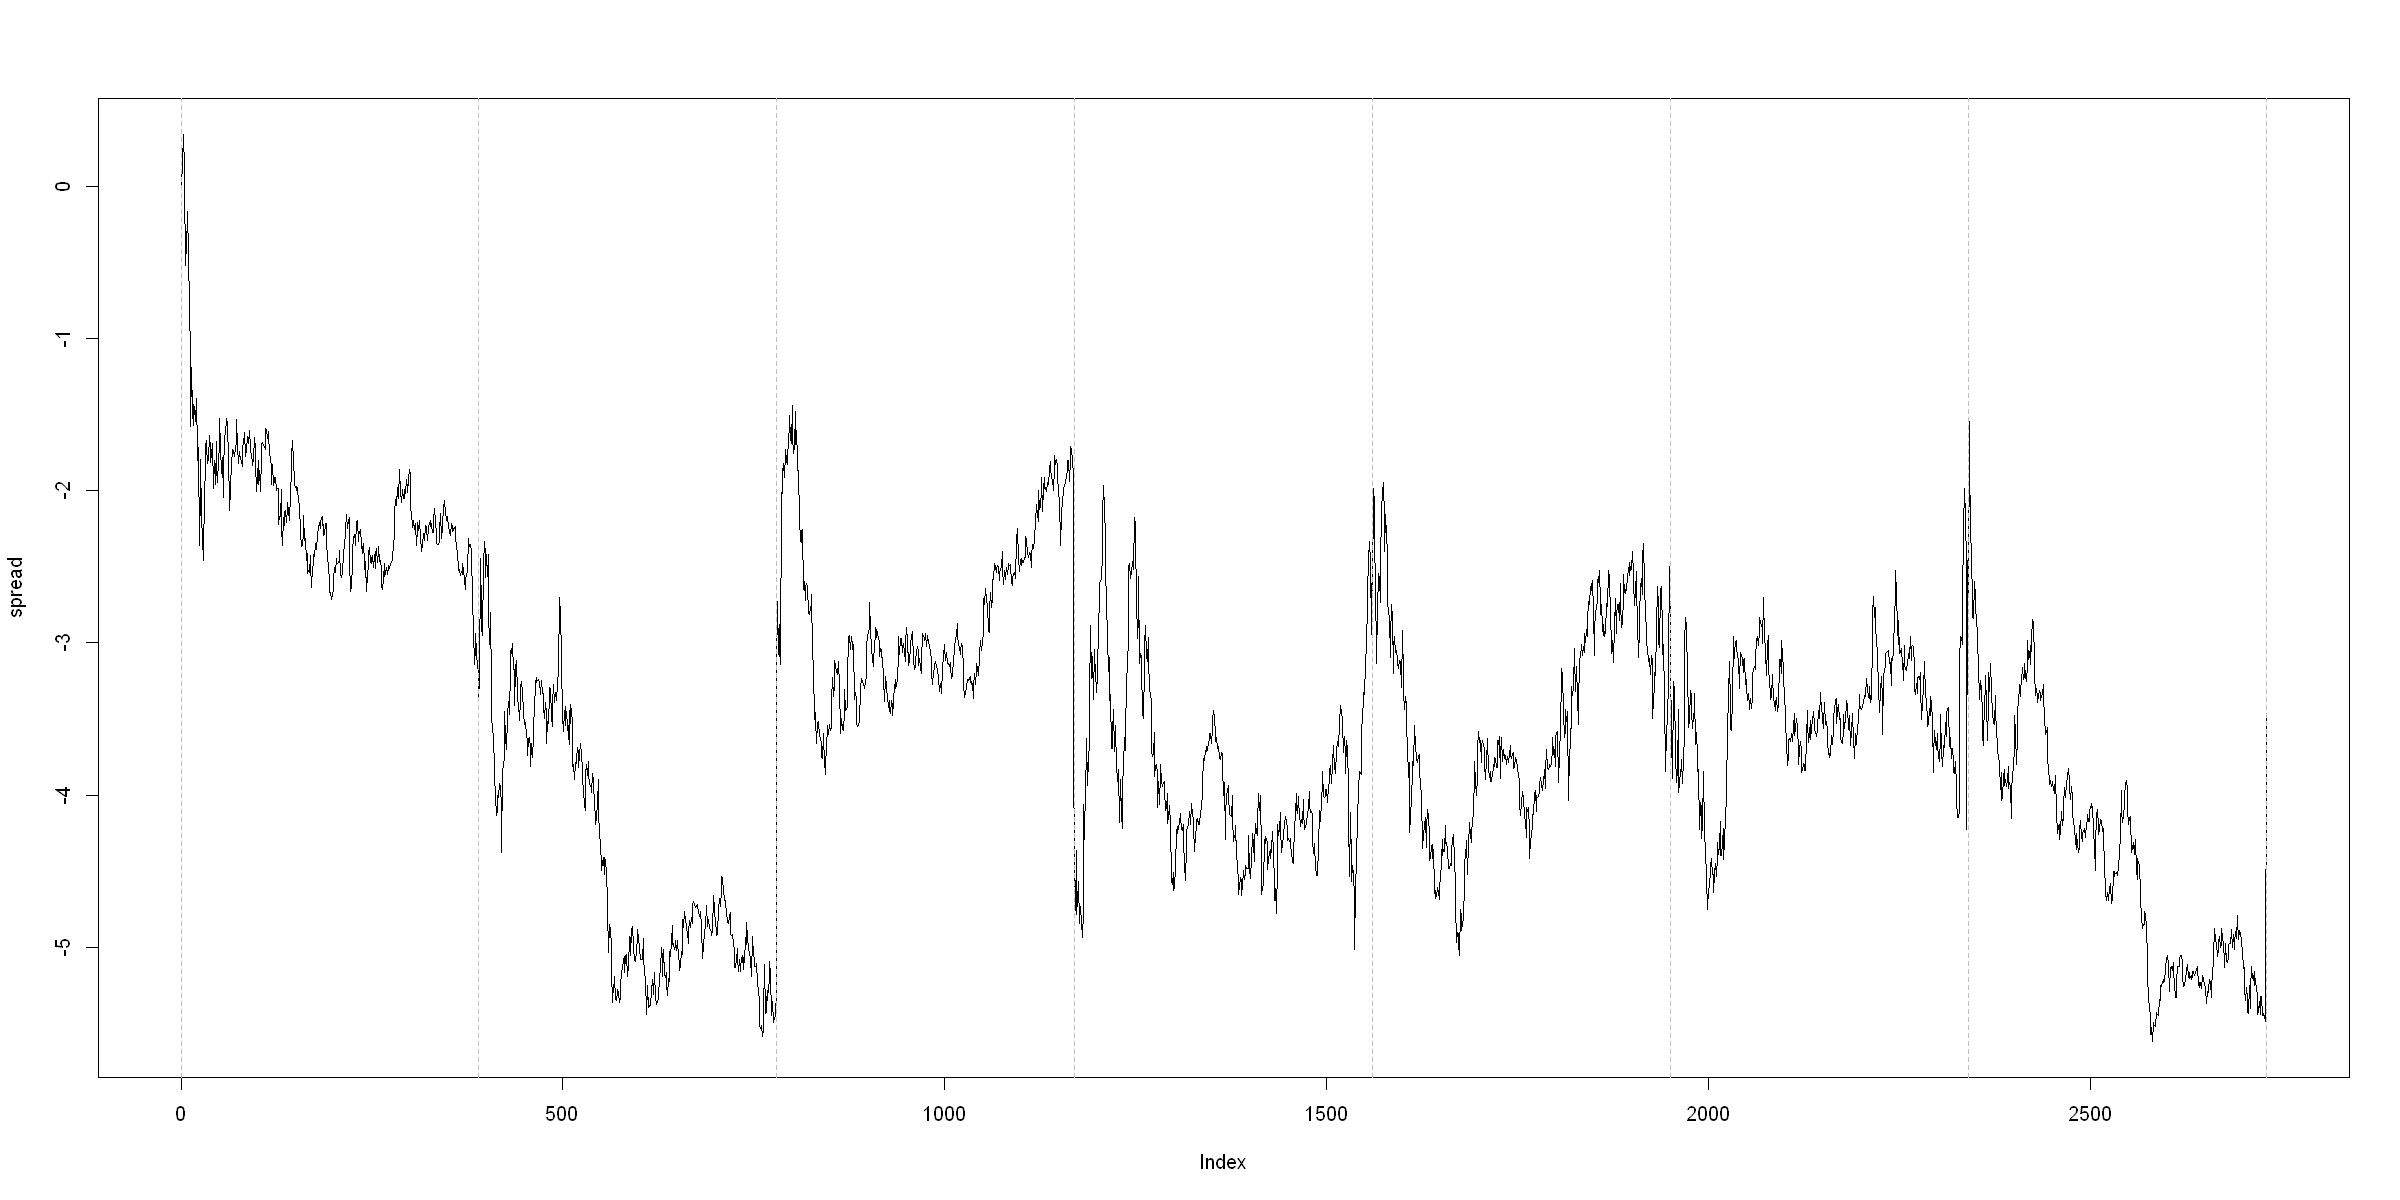

In [6]:
# We consider the spread of the log returns to be a stationary time series.
plot(spread, type='l')

# Vertical lines indicate days
vline = as.numeric(seq(0, length(spread), by = 390))
abline(v = vline, col='gray', lty=2)

# Jump Detection & Estimation

We apply the method in Fonseca & Ignatieva (2019) for daily jump detection. 

Let $r_{t,i} = y_{t, i\Delta} - y_{t, (i-1)\Delta}$. The realized variance (RV) is given by

##### $ RV = \sum_{i=1}^m r_{t,i}^2 $, 

We consider the RV for each day, which has 390 observations.

In [7]:
m = 390
delta = 1 / m
noObs = ceiling(seq_along(spread)/m)

# Split the dataset per m observations
spreadInterval = split(spread, noObs)

In [8]:
rtInterval = array()
noInterval = length(spreadInterval)

# Calculates for the differenced series rtInterval
for (i in 1: noInterval) {

    rtInterval[i] = list(diff(spreadInterval[[i]]))
}

In [9]:
# This type of loop will be used repeatedly throughout the code.
realizedVarInterval = array()

# Calculates RV
for (i in 1: noInterval) {

    # Resets the productTemp array for each subset    
    productTemp = array()

    # Iterates over each observation in rtInterval to get the sum (incase the number of observations are not the same everyday)
    for (k in 1: length(rtInterval[[i]])) {

        productTemp[k] =  ( rtInterval[[i]][k] )^2
    }

    realizedVarInterval[i] = sum(na.omit(productTemp))
}

realizedVarInterval = na.omit(realizedVarInterval)

The realized bipower variation (BV) is given by

##### $BV = \frac{\pi}{2} \frac{m}{m-1} \sum_{i=2}^m |r_{t,i}| |r_{t,i-1}| $

In [10]:
sumInterval = array()
bipowerVarInterval = array()

# Calculates BV
for (i in 1: noInterval) {
  
    productTemp = array()

    for (k in 2: length(rtInterval[[i]])) {

        productTemp[k] =  abs(rtInterval[[i]][k]) * abs(rtInterval[[i]][k-1]) 
    }

    sumInterval[i] = sum(na.omit(productTemp))
    bipowerVarInterval[i] = (pi / 2) * m / (m-1) * sumInterval[[i]]
}

bipowerVarInterval = na.omit(bipowerVarInterval)

Next, we calculate the magnitude of the jumps. The test statistic is given by 
##### $RJ = \frac{RV-BV}{RV}$

In [11]:
RJV = realizedVarInterval - bipowerVarInterval
RJ = RJV / realizedVarInterval

Let TP be the tripower quarticity that is robust to jumps, 

##### $\mu_{4/3} = 2^{2/3} \frac{\Gamma( (7/6)))}{\Gamma(1/2)} $

##### $TP = m \mu_{4/3}^{-3} \frac{m}{m-2} \sum_{t=3}^m |r_{t, i-2}|^{4/3} |r_{t, i-1}|^{4/3} |r_{t,i}|^{4/3} $

In [12]:
mu = (2^(2/3)) * gamma(7/6) / gamma(1/2)

In [13]:
tripowerInterval = array()

# Calculates TP
for (i in 1:  length(rtInterval)) {
    
    productTemp = array()

    for (k in 3: length(rtInterval[[i]])) {

        productTemp[k] = abs(rtInterval[[i]][k-2])^(4/3) * abs(rtInterval[[i]][k-1])^(4/3) * abs(rtInterval[[i]][k])^(4/3)
    }

    sumInterval[i] = sum(na.omit(productTemp))
    tripowerInterval[i] = m * (mu)^(-3) * m / (m-2) * sumInterval[[i]]
}

The test statistic converges in distribution to a Gaussian distribution when we use the scaling:

 ##### $ZJ_t = \frac{RJ_t}{\sqrt{ [ (\frac{\pi}{2})^2 + \pi -5] \Delta Max(1, \frac{TP_t}{BV_t^2}) } } $

In [14]:
ZJ = array()

# Calculates for ZJ
for (i in 1:length(RJ)) {
    
    ZJ[i] = RJ[i] / ( ( (pi/2)^2 + pi - 5) * delta * max(1, tripowerInterval[i]/bipowerVarInterval[i]) )^(1/2)
}

The magnitude of the jump Jt is given by

##### $J_t = sign(r_t) \times \sqrt{ (RV- BV) \times I_{ZJ \ge \Phi_\alpha^{-1}} }$

since $r_{t,i} = y_{t,i\Delta} - y_{t, (i-1)\Delta} $, I assume that $r_t = y_t - y_{t-1} $,  where $y_t = dailyreturn_{t} - dailyreturn_{t-1} $  

In [15]:
# Computes for the sign of rt
retCurrent = array()
retPrevious = array()
ret = array()

# for interval 1 we take sign(rt) = sign[ day one's (spread_10 - spread_1) ]
intervalOne = sign( spreadInterval[[1]][length(spreadInterval[[1]])] - spreadInterval[[1]][1] )
ocSpread = array(intervalOne) 

# Computes for the spread as the difference between the the second interval's start price and the previous interval's ending price
for (i in 2: noInterval) {

    # calculate the return on day t (y_t)
    retCurrent[i] =  spreadInterval[[i]][length(spreadInterval[[i]])] - spreadInterval[[i]][1]
    retPrevious[i] = spreadInterval[[i-1]][length(spreadInterval[[i-1]])] - spreadInterval[[i-1]][1]
    ret[i] = retCurrent[i] - retPrevious[i]

    rt = append(ocSpread, ret)
}

sign = sign(na.omit(rt))

In [16]:
# This calculates the area under the inverse cumulative distribution function. 
# We run a monte carlo algorithm
alpha = 0.90
x = rnorm(100000, 0, 1)
pdf = density(x)

# Interpolate the density
f = approxfun(pdf$x, pdf$y, yleft=0, yright=0)

# Get the cdf by numeric integration
cdf = function(x){

  integrate(f, -Inf, x)$value
}

# Use a root finding function to invert the cdf
invcdf = function(q){

  uniroot(function(x){cdf(x) - q}, range(x))$root
}

threshold = as.numeric(invcdf(alpha))

In [17]:
# Let ZJ be the indicator function, we replace non-statistically significant values with zero.
for (i in 1:  length(ZJ)) {
    
    if (ZJ[i] > threshold) {

        ZJ[i] = 1
    }

    else {
        ZJ[i] = 0
    }
}

The magnitude of the jumps are given by JT

In [18]:
JT = sign * ( RJV * ZJ )^(1/2)

# Removing the Jumps from the process

We assume that if a jump was detected on day t, then the jump occured in between the close price of interval t-1 and the open price of interval t. Thus, the jump affected the opening price of interval t

In [19]:
# Remove the jumps by subtracting the magnitude of the jump to the first price at interval t
jumpInterval = which(JT!=0, arr.ind = T)

# Replaces the price with (price - jump) on jumpInterval
for (i in 1:  length(spreadInterval)) {
    
    if (i %in% jumpInterval) {
        spreadInterval[[i]] = replace(spreadInterval[[i]], 1, spreadInterval[[i]][1] - JT[i])
    }
}

In [20]:
# The frequency lambda is given by the number of days where a jump occurs divided by the total number of days
lambda = length(jumpInterval) / noInterval

# Let k be the size of the jumps
k = mean(JT)

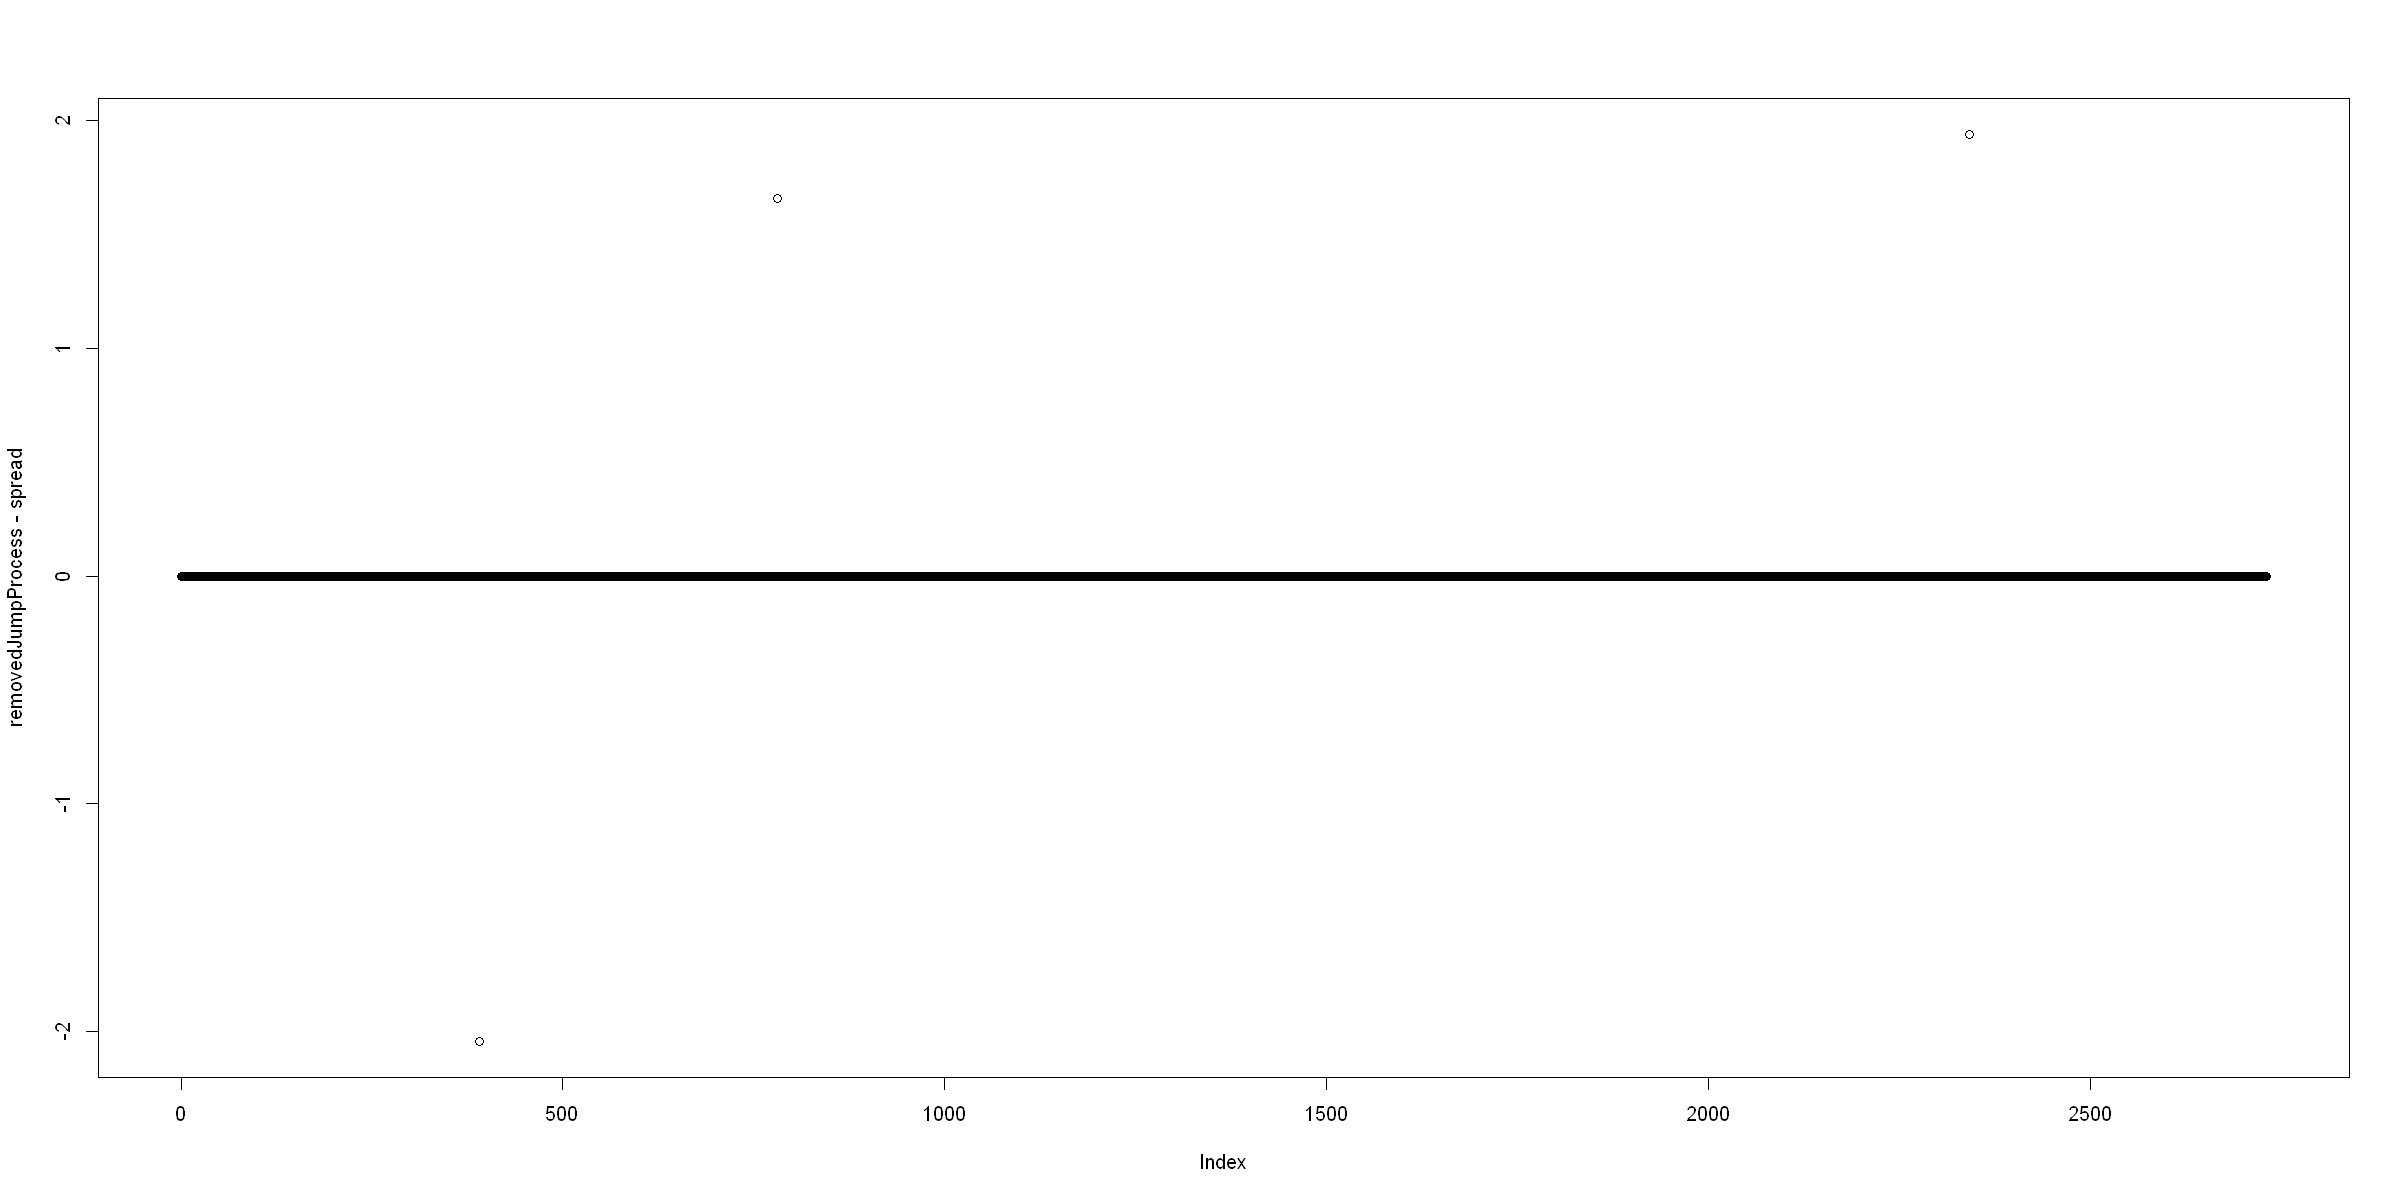

In [21]:
removedJumpProcess = unlist(spreadInterval)

plot(removedJumpProcess - spread)

# Estimation of Parameters

Now that we have removed the jumps, we have a standard diffusion process of the form

##### $ dU_t = -\mu U_tdt + \sigma dW_t $

In [22]:
 ou.lik = function(x) {

  function(theta1, theta2, theta3) {
    
    n = length(x)
    dt = deltat(x)

    -sum(dsOU(x = x[2:n],
      theta = c(theta1, theta2, theta3), log=TRUE))
  }
}

ou.fit = mle(ou.lik(removedJumpProcess),
          start = list(theta1 = mean(spread), theta2 = 0.2, theta3 = 1),
          method="L-BFGS-B")
  
ou.coe = coef(ou.fit)
ou.coe

theta1     theta2     theta3 
-3.4322821  0.9775636  1.4001810

Note that dsOU returns the following model so we have to adjust the parameters to replicate our model

$ dX = (\theta_1 - \theta_2X_t)dt + \theta_3 dW $

In [23]:
mean = ou.coe[[1]]/ ou.coe[[2]]
mu = ou.coe[[2]]
sigma = ou.coe[[3]]

To solve the Optimal Exit Strategy, our approach is to solve the boundary value problem

##### $ L v = - \mu x, \quad  x \in (\alpha, \beta) $

##### $ v(x) = 0, \quad  x \notin (\alpha, \beta) $

where 

##### $ Lv = \mathbb{D}v - \lambda \mathbb{J}v $

then set $ \alpha < 0 $ and find $ \beta > \alpha $ such that $v'(\beta) = 0 $

# Finite Differences

We apply the finite differences method defined below for non-jump components

$  v'(x_i) \approx \dfrac{v(x_{i}) - v(x_{i-1})}{\Delta x}  $


$ v''(x_i) \approx \dfrac{v(x_{i+1}) - 2v(x_i) + v(x_{i-1})}{(\Delta x)^2} $

In [24]:
deltaX = length(spread)
firstDifference = array()
secondDifference = array()

# Approximate the first derivative
for (i in 2:  length(spread)- 1) {
        firstDifference[i-1] = spread[i] - spread[i-1] 
}
firstDerivative = firstDifference/deltaX

# Approximate the second derivative
for (i in 2:  length(spread) - 1) {
        secondDifference[i-1] = spread[i+1] - 2 * spread[i] + spread[i-1] 
}
secondDerivative = secondDifference/deltaX**2

$ \mathbb{D}v \approx \mu x \dfrac{v(x_{i}) - v(x_{i-1})}{\Delta x}  - \frac{1}{2} \sigma^2 \dfrac{v(x_{i+1}) - 2v(x_i) + v(x_{i-1})}{(\Delta x)^2} $

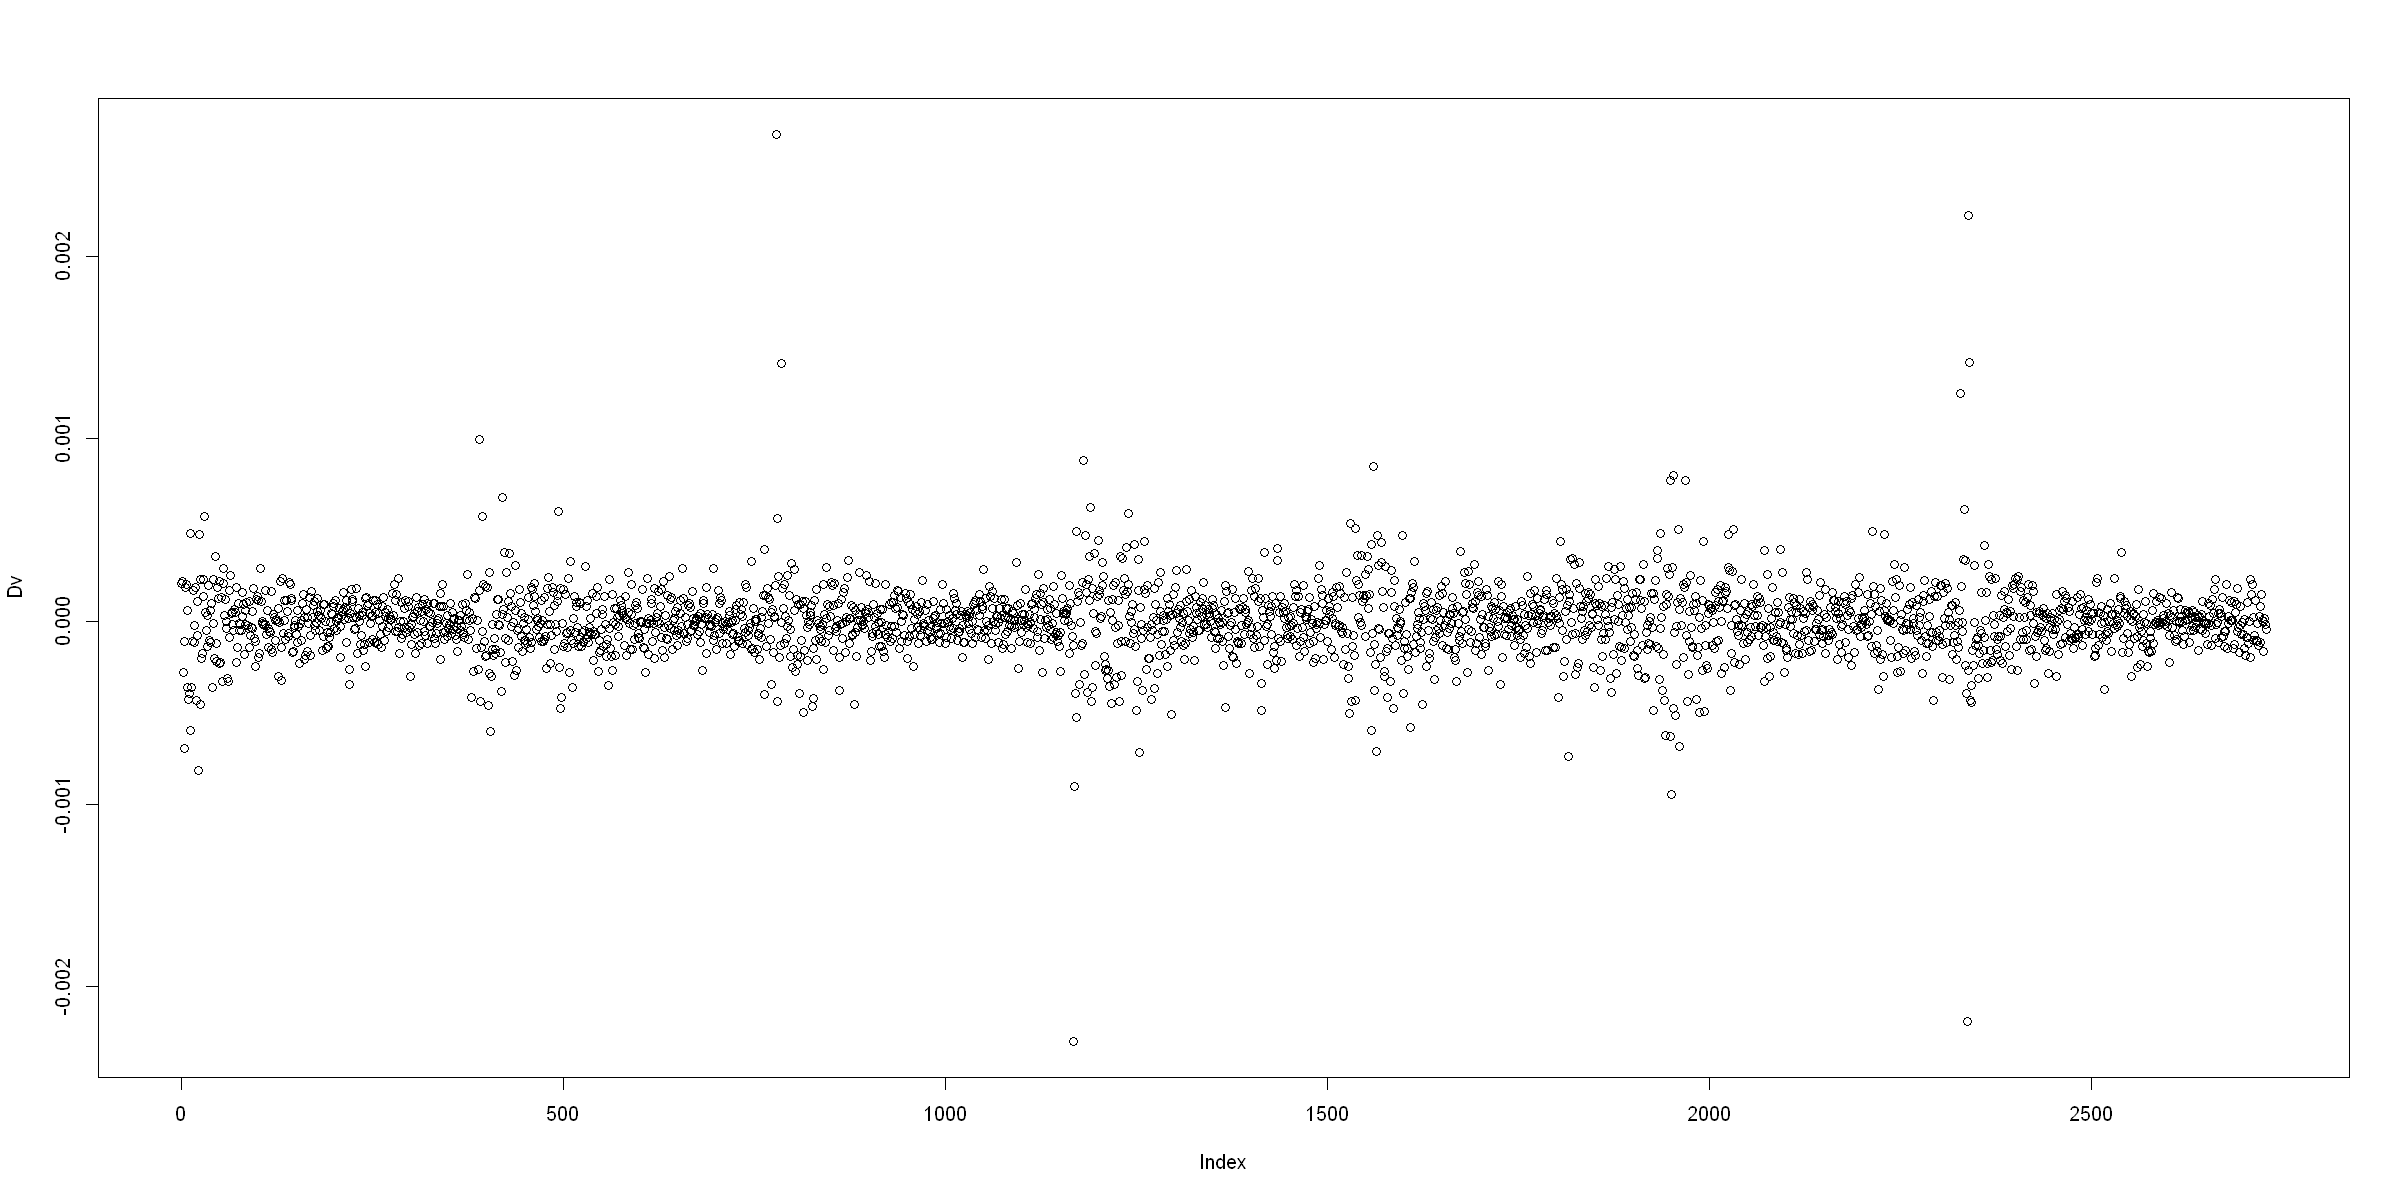

In [25]:
Dv = as.numeric(mu * initialValue * firstDerivative - (1/2) * sigma^2 * secondDerivative)
plot(Dv)

# Gauss-Hermite Quadrature

We assume that jumps are normally distributed and apply Gauss-Hermite Quadrature to approximate 

##### $ Jv = \int_{-\infty}^{\infty}[v(x+y)-v(x))] \varphi(y) d y $

First, we interpolate the process using cubic splines since we are modeling a jump-process

In [26]:
x <- seq(spread)
y <- spread

# Forsythe, Malcolm and Moler (an exact cubic is fitted through the four points at each end of the data, and this is used to determine the end conditions)
splinePoly = splinefun(x=x, y=y, method="fmm")

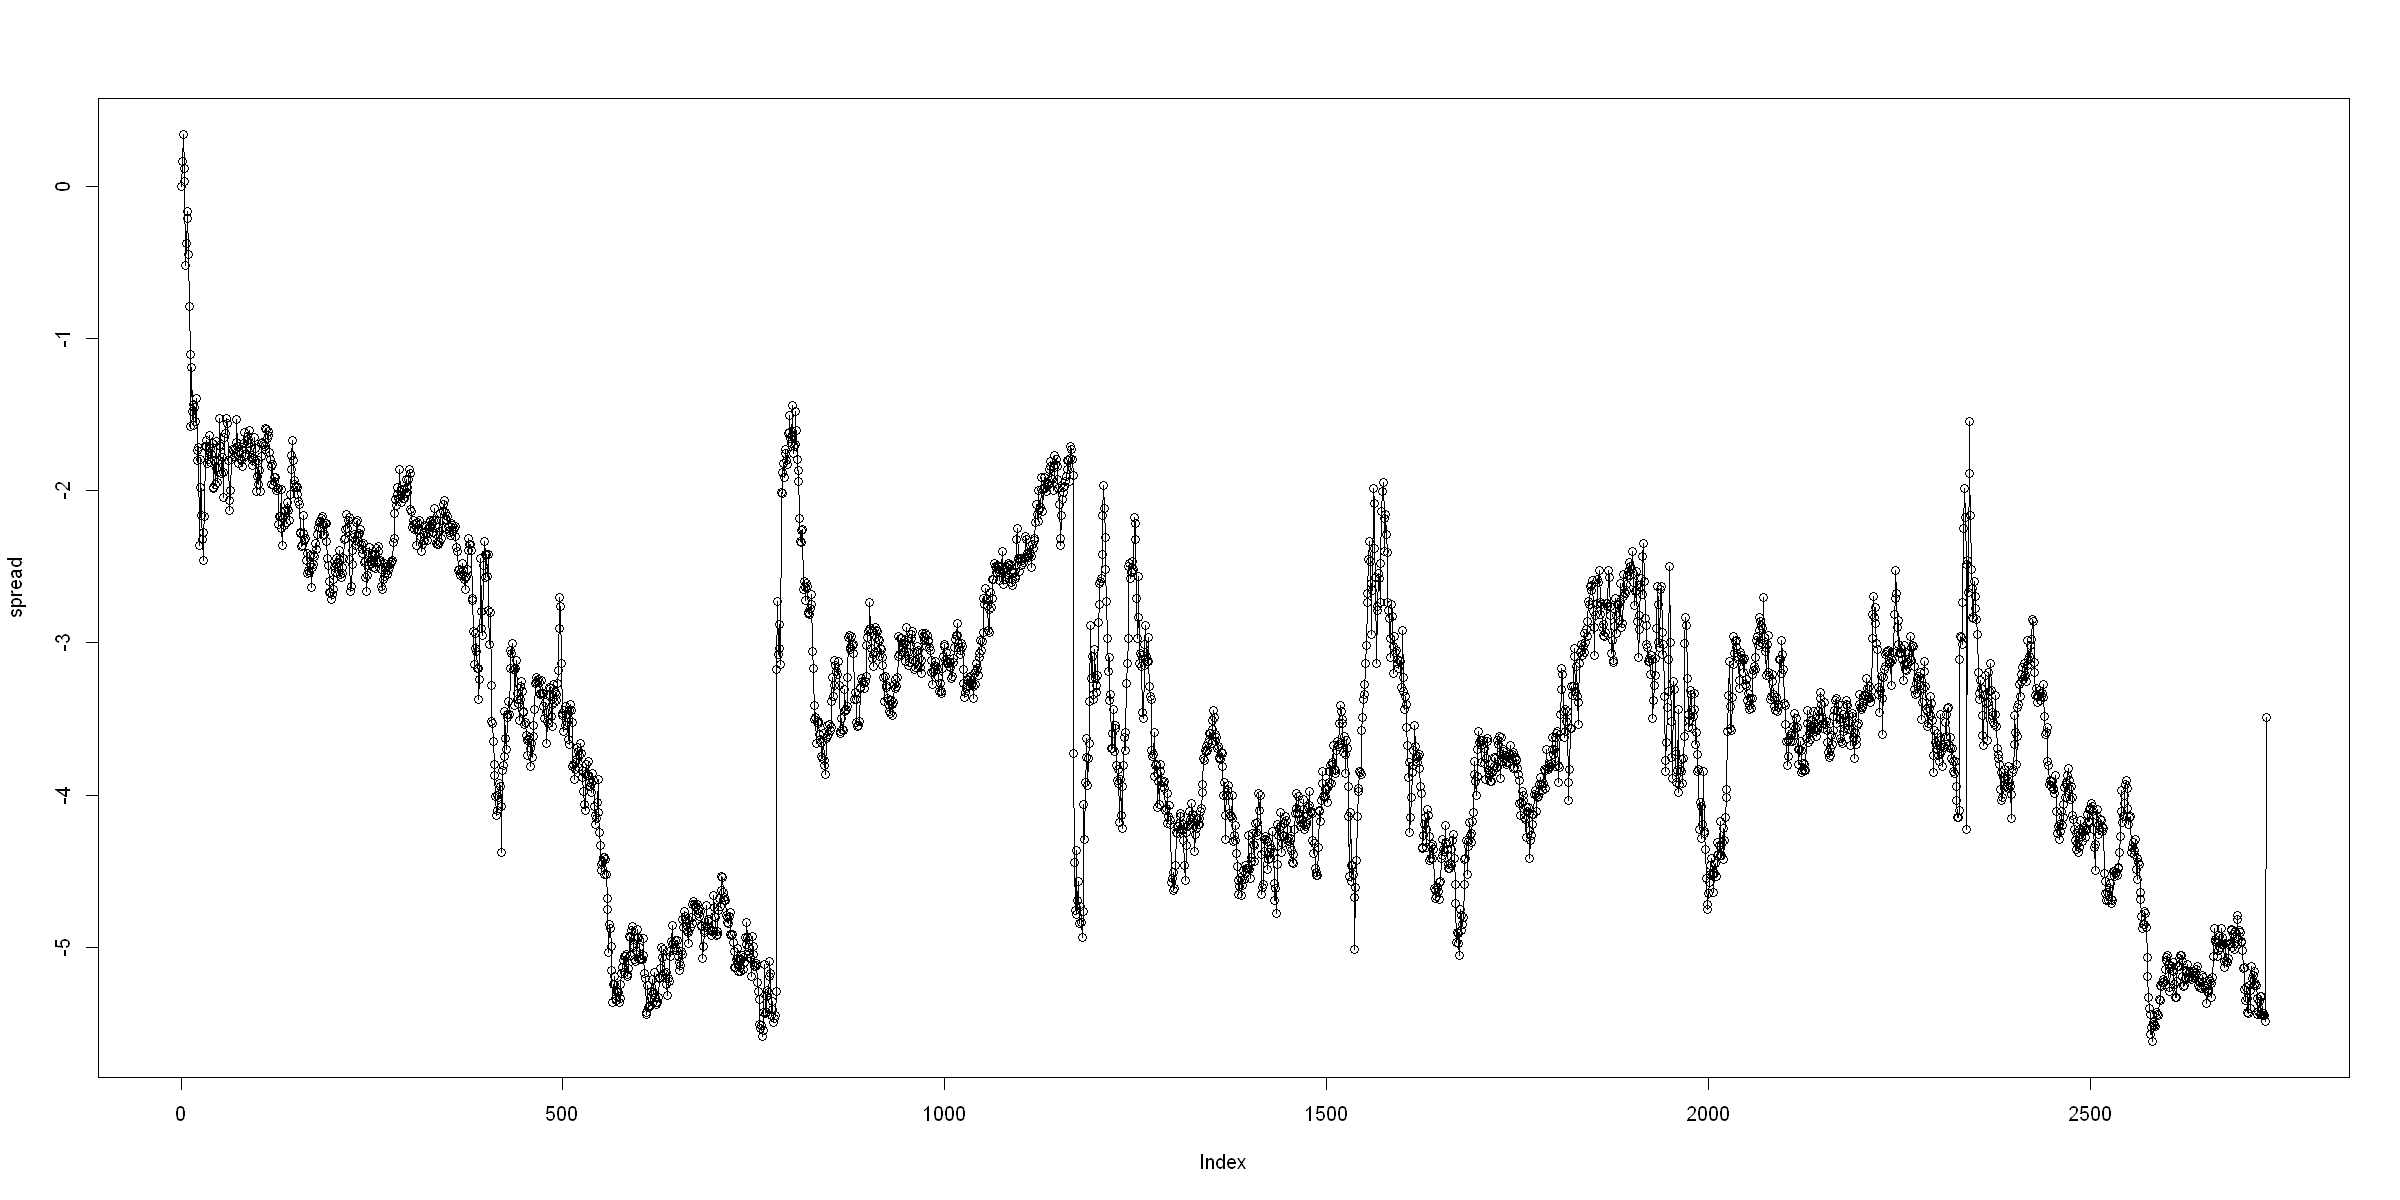

In [27]:
# Plot the polynomial Interpolation versus the actual process
SplinePolyProcess = as.numeric(lapply(seq(length(spread)), splinePoly))
plot(spread)
lines(SplinePolyProcess)

$ \int_{-\infty}^\infty v(x_i+y)\varphi(y) d y \approx \sum_{j=1}^L w_j v(x_i + y_j)$

where y is the jump magnitude and we interpolate $v(x_i + y_j)$ for $j=1,2,\dots,L$ from known values of $v(x_i)$, $i=1,2,\dots,M$.

In [28]:
# Set 3000 nodes for gauss-hermite quadrature
rule = gaussHermiteData(3000)

# Calculates the value of the integral from -inf to inf [ v(x) * e^{-x^2} ]
vOfX = ghQuad(splinePoly, rule) 

In [29]:
# Caclulates v(x+y)
xPlusk <- seq(spread) + k 

splinePolyPlusk = splinefun(x=xPlusk, y=y, method="fmm")

vOfXPlusY = ghQuad(splinePolyPlusk, rule)

In [30]:
Jv = vOfXPlusY - vOfX

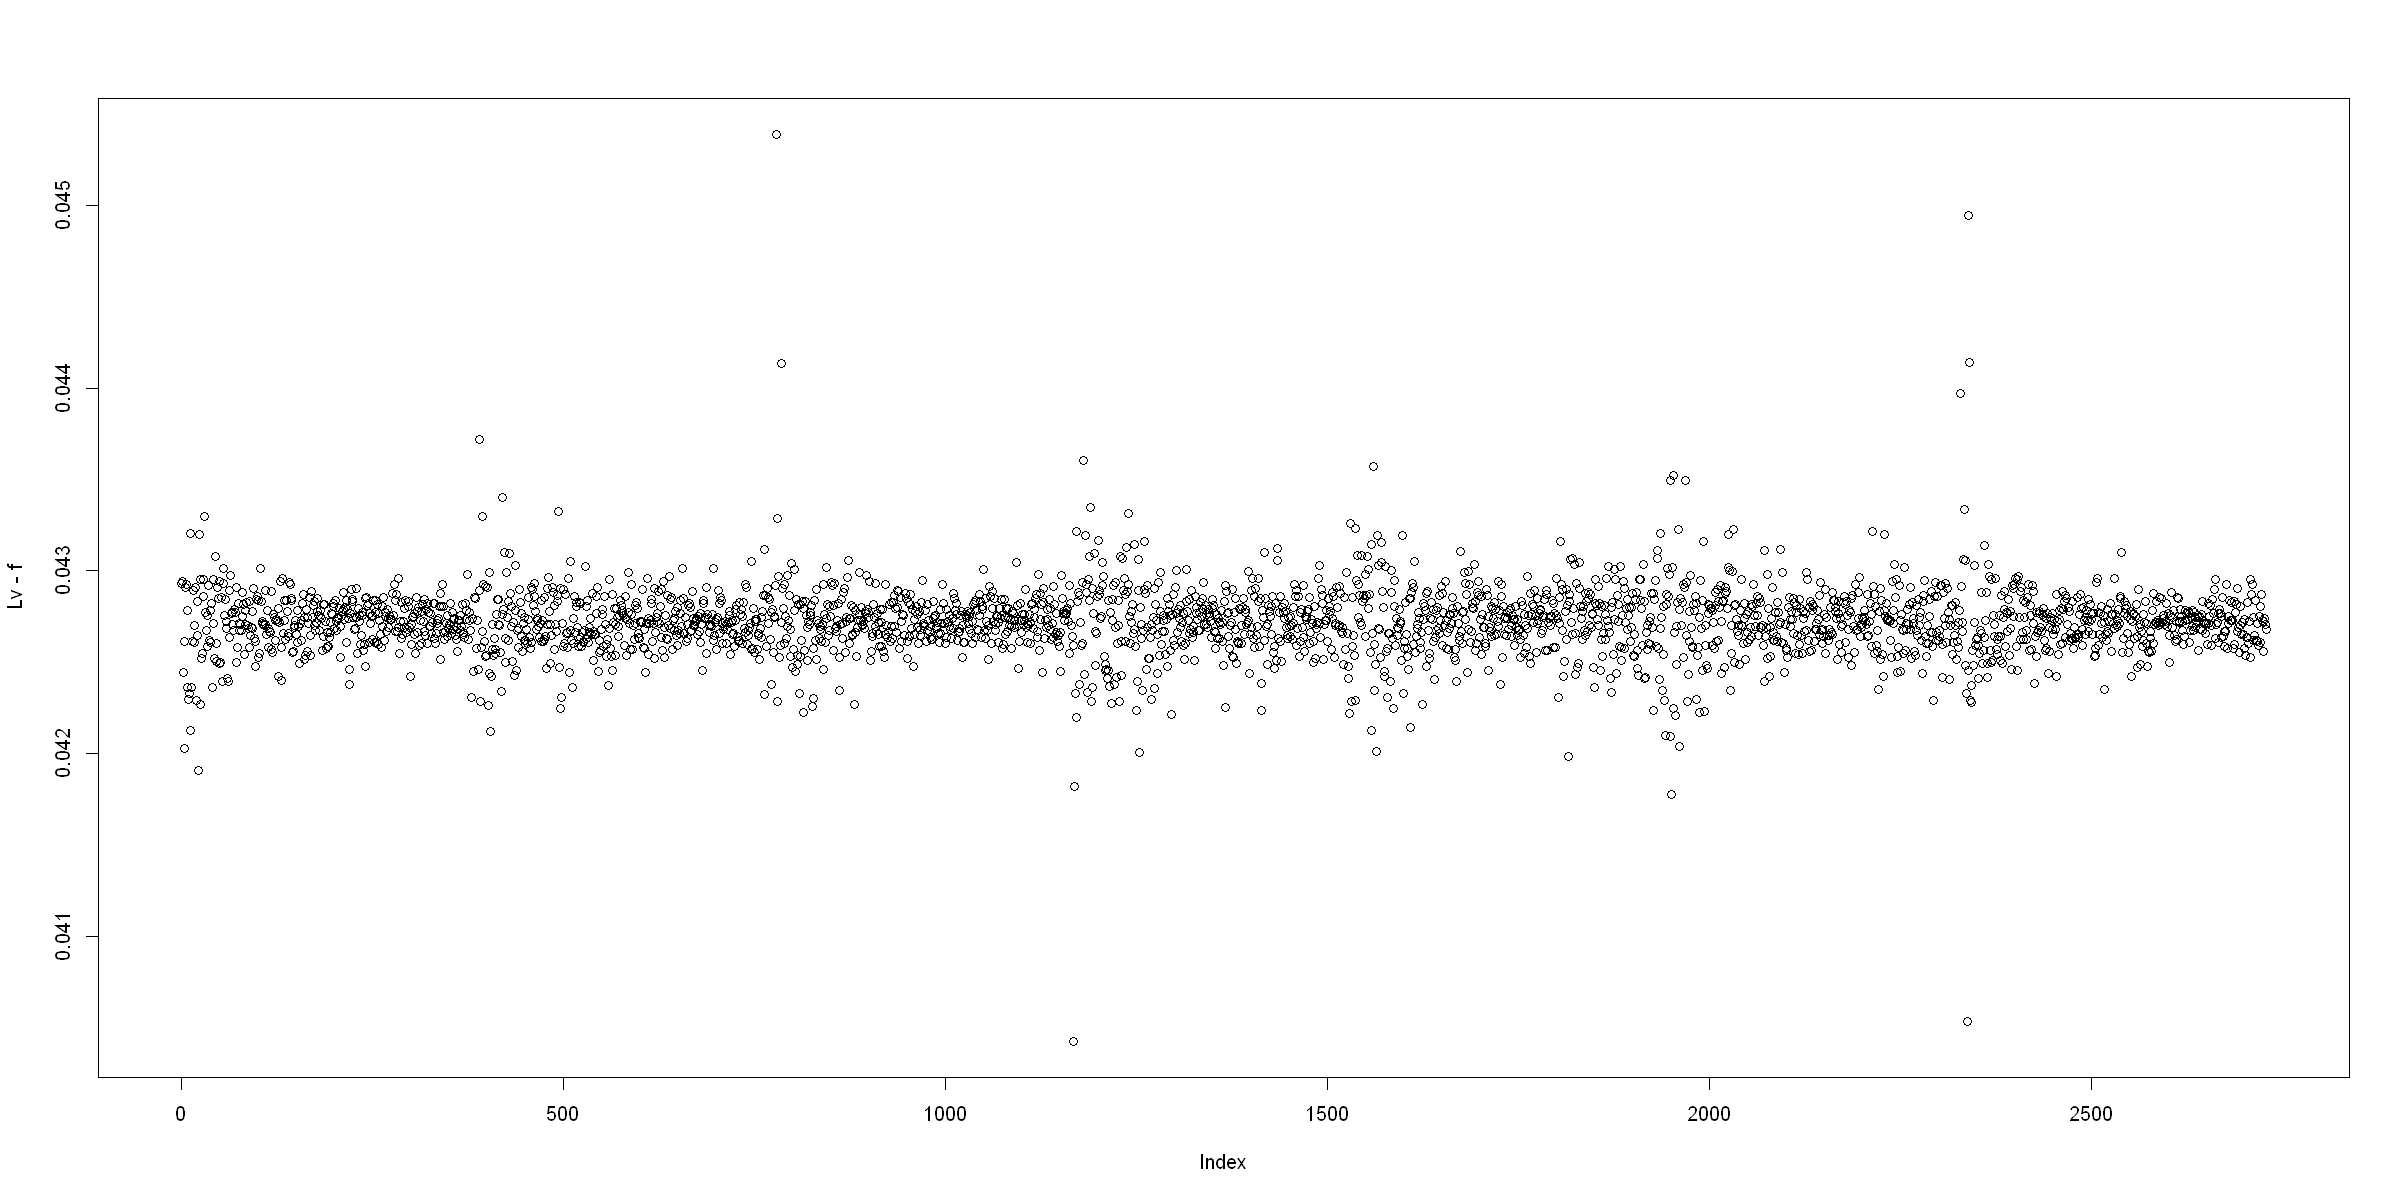

In [31]:
Lv = Dv - lambda * Jv 
# we have to adjust f by the mean since our mean isn't zero
f = - mu * initialValue - mean

plot(Lv - f)

In [32]:
# This is the condition where v'(\beta) = 0
# Set values below threshold to zero 
thresholdDeriv = 0.00001

firstDerivative[ abs(firstDerivative) < thresholdDeriv]  = 0
betaOptimal = which(firstDerivative == 0)[1]

betaOptimal

[1] 17

In [33]:
# This is the condition where Lv = f
thresholdLv = 0.5

# Since f = -mu * spread, we consider Lv - f = 0
LvDifference  = Lv - f
LvDifference[ abs(LvDifference) < thresholdLv]  = 0
LvZeros = which(LvDifference == 0)

# Contains x that satisfy Lv = - \mu * x
length(LvZeros)

[1] 2728

In [34]:
# Generates an array of prices that satisfies Lv = f
priceTracker = lapply(LvZeros, splinePoly)

supremum = max(as.numeric(priceTracker))
supremumIndex = LvZeros[which.max(priceTracker)]

In [35]:
# set an alpha value as the lower bound and compare which among alpha and beta occur first and exit there
alpha = -2

thresholdAlpha = 0.1

spread[ spread - alpha <= thresholdAlpha]  = 0

# We chose the second occurence since the first occurence is 0 from homogenizing the boundary condition.
alphaOptimal = which(spread == 0)[2]
alphaOptimal

[1] 24

In [36]:
# First hitting time of the boundary
if (alphaOptimal < betaOptimal) {
    optimal = alphaOptimal
} else { 
    optimal = betaOptimal
}

# Make the spread zero after the first hitting time of the boundary
spread[optimal: length(spread)] = 0

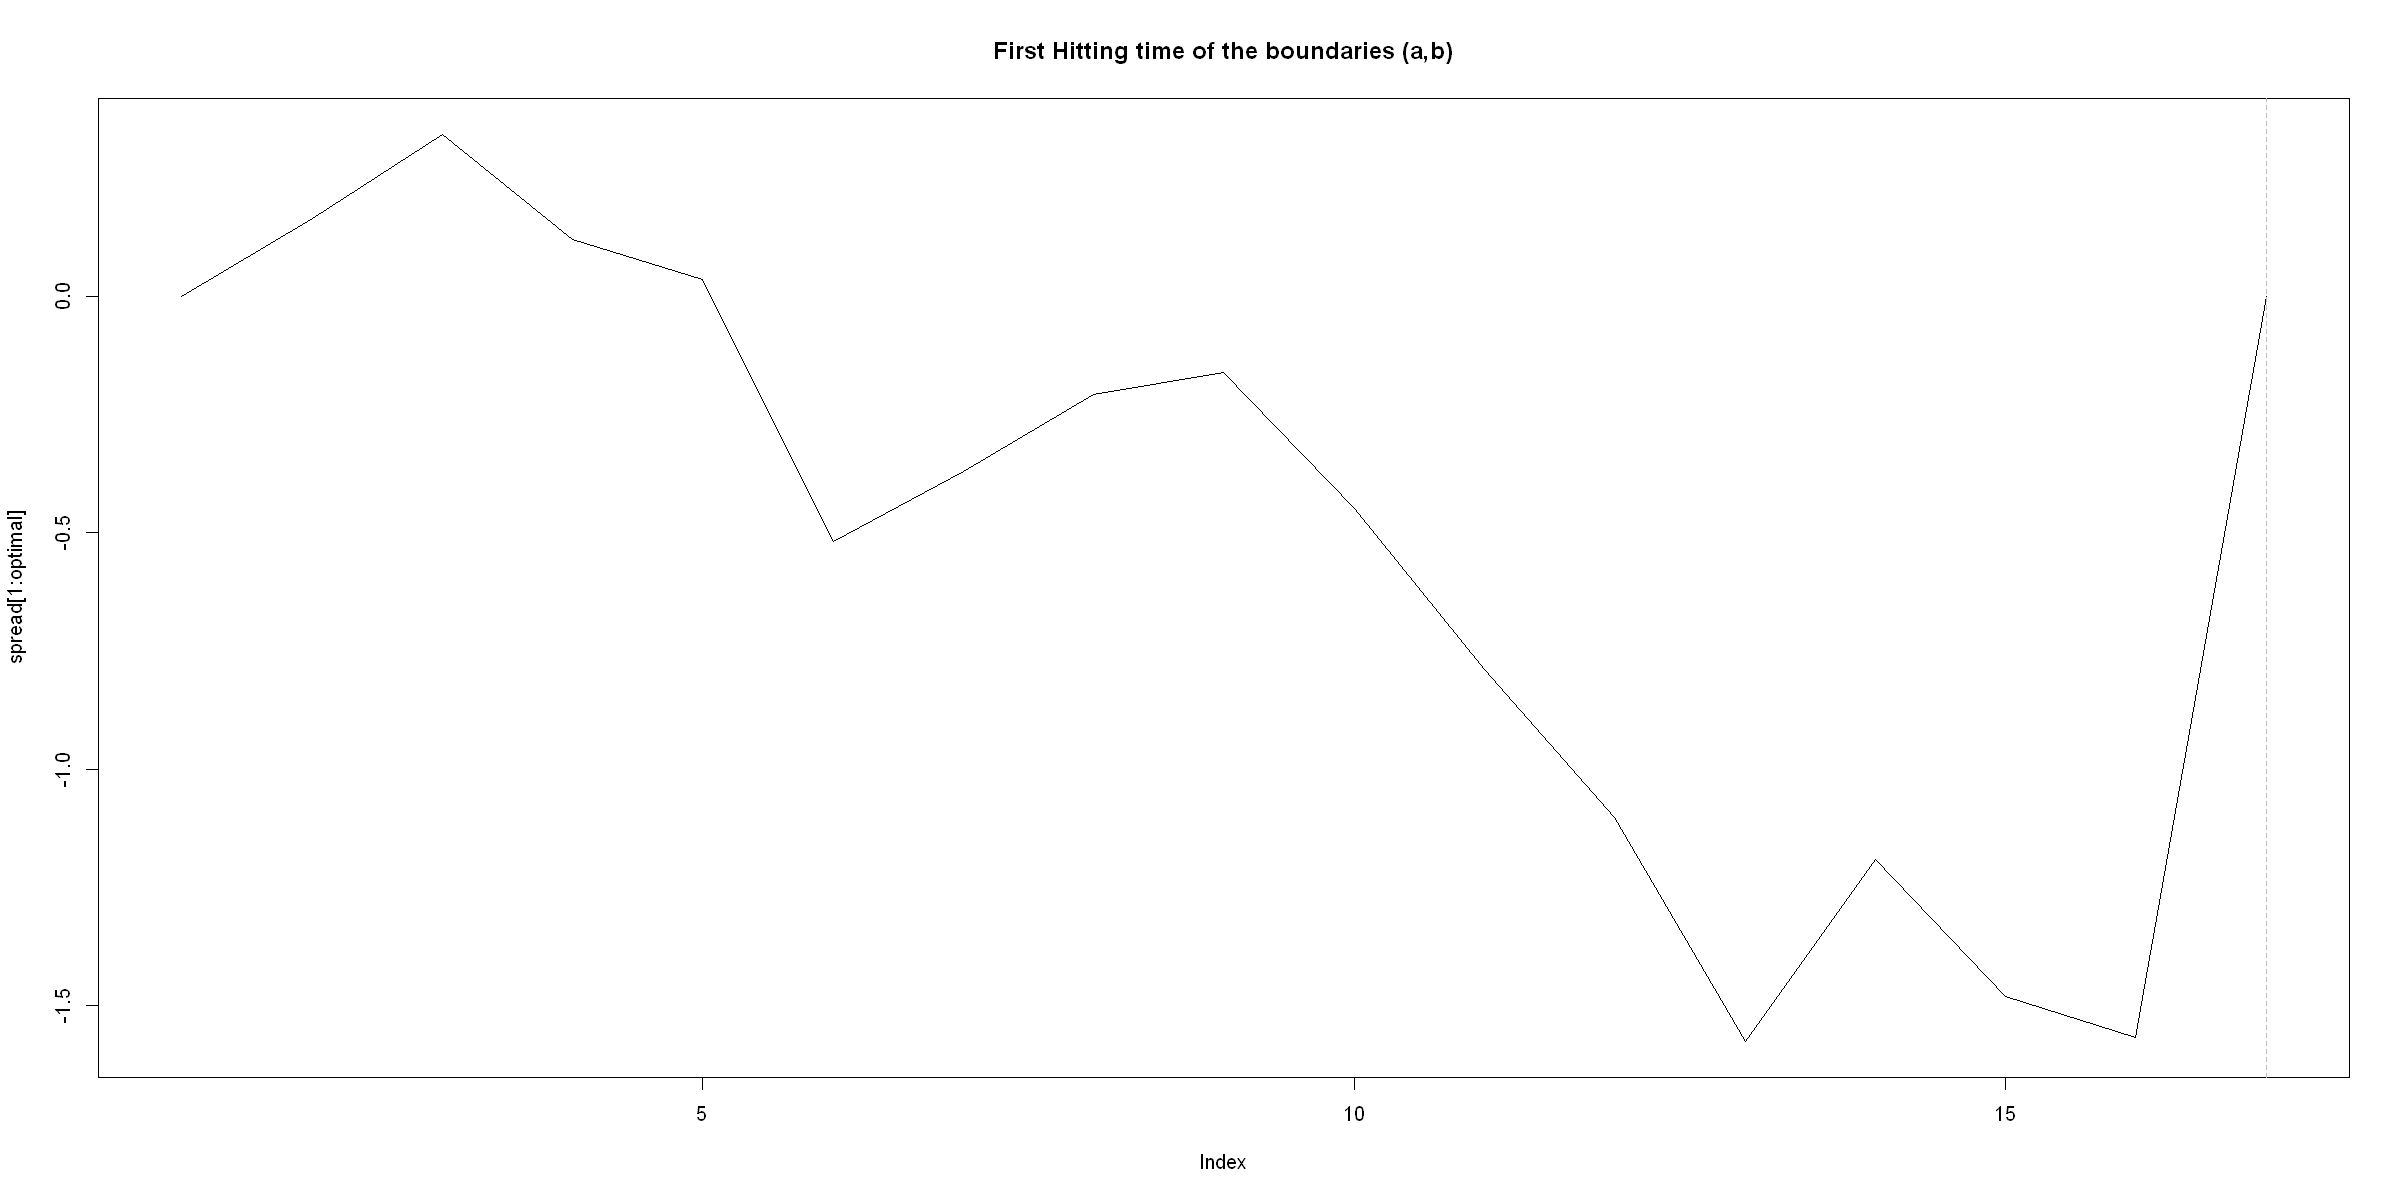

In [37]:
plot(spread[1: optimal], type= 'l', main = 'First Hitting time of the boundaries (a,b)')
abline(v = optimal, col='gray', lty=2)

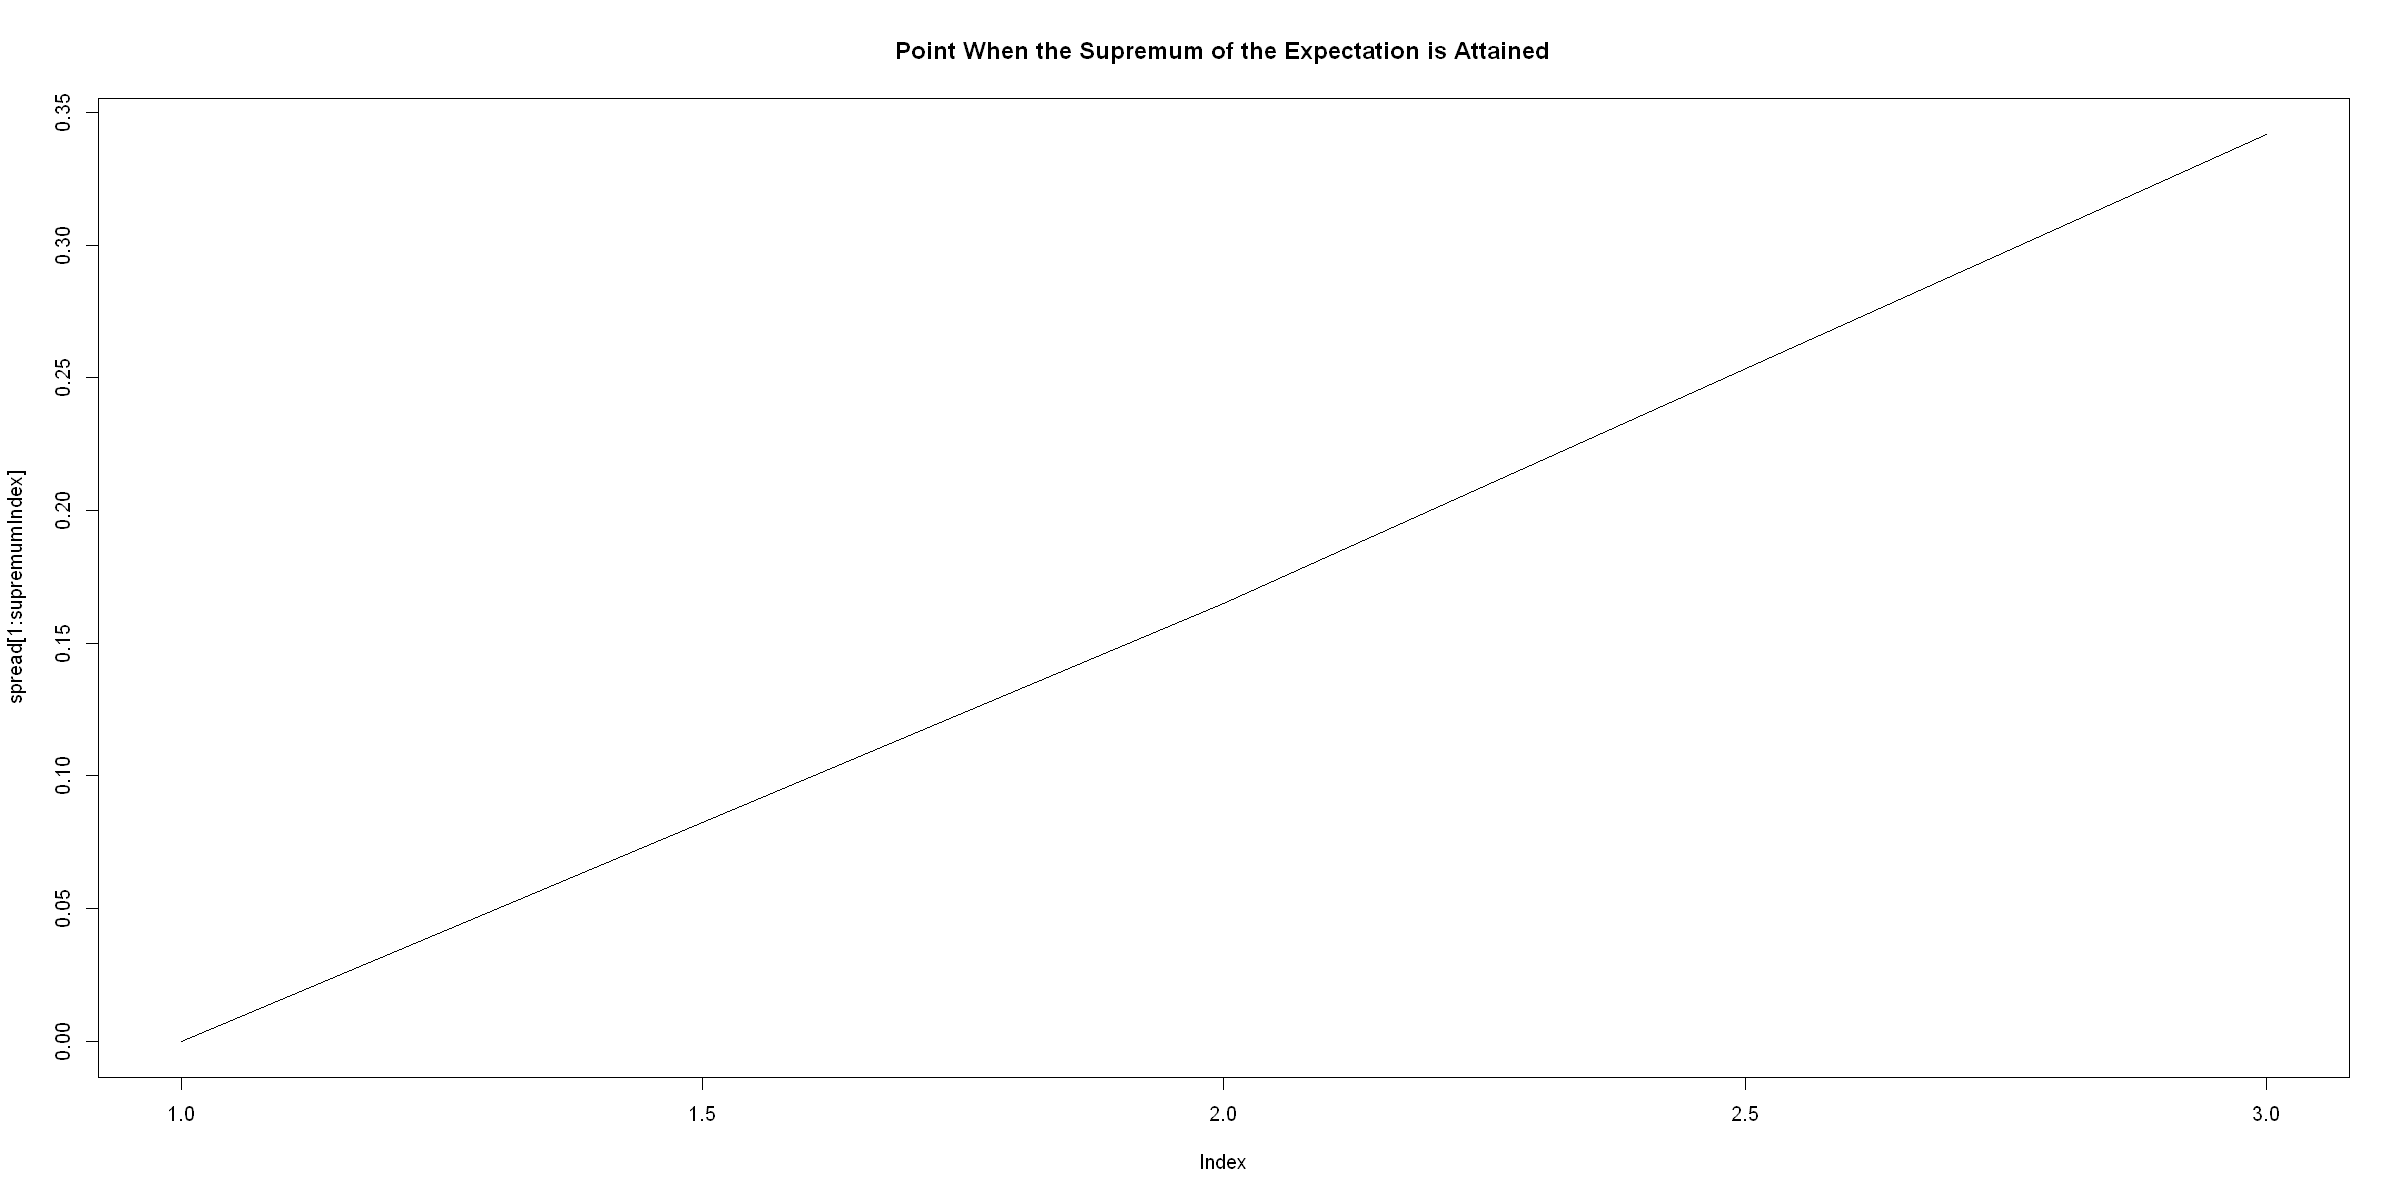

In [38]:
plot(spread[1: supremumIndex], type= 'l', main = 'Point When the Supremum of the Expectation is Attained')